In [3]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib
from matplotlib.lines import Line2D
import calendar as cal
import plotly.figure_factory as ff
import matplotlib.dates as mdates

from modules import constants 
from modules import conc2abs as ca
from modules import utils as ut
from modules import data_processing as dp
from modules import data_retrieval as dr 
from modules import statistics as st
from modules import seasonal_data_grouper as sdg
from eval import *
%matplotlib inline

In [4]:
method = 'SLSQP'
path_ri = 'ri_tables/'
#reading stations from json file
with open('stations/stations.json') as json_file:
    stations = json.load(json_file)

# Ordenar las estaciones por latitud
estaciones_ordenadas = sorted(stations.items(), key=lambda x: x[1]['latitude'])
#invertir el orden
estaciones_ordenadas = estaciones_ordenadas[::-1]

dict_of_names = {}
with open('modules/conv_stat_names.json') as file:
    dict_of_names = json.load(file)
    
stations = list(dict_of_names['acr_first'].keys())[::-1]
stations

['HYY',
 'HEL',
 'KRA',
 'SIR',
 'OPE',
 'RIG',
 'PAY',
 'IPR',
 'MAR',
 'MSY',
 'BCN',
 'DEM']

In [22]:
data_nosoa = {}

# Iterar sobre cada estación
for stn in stations:
    # Cargar los dataframes para la estación actual
    #weakly_by_stn = pd.read_csv(f"{path_ri}monarch_best_weakly/RI_by_station/no_secondary/RI_{method}_{dict_of_names['acr_first'][stn]}_best.csv", index_col=0)
    #moderately_by_stn = pd.read_csv(f"{path_ri}monarch_best_moderately/RI_by_station/no_secondary/RI_{method}_{dict_of_names['acr_first'][stn]}_best.csv", index_col=0)
    #strongly_by_stn = pd.read_csv(f"{path_ri}monarch_best_strongly/RI_by_station/no_secondary/RI_{method}_{dict_of_names['acr_first'][stn]}_best.csv", index_col=0)
    new_case = pd.read_csv(f"{path_ri}monarch_best_newcase/RI_by_station/no_secondary/RI_{method}_{dict_of_names['acr_first'][stn]}_best.csv", index_col=0)
    #oa_by_stn = pd.read_csv(f"{path_ri}monarch_best_oa/RI_by_station/RI_{method}_{dict_of_names['acr_first'][stn]}_best.csv", index_col=0) 
    new_case_all = pd.read_csv(f'ri_tables/monarch_best_newcase/RI_all/no_secondary/RI_SLSQP_best.csv', index_col=0)
    data_oa_tot = pd.read_csv(f'ri_tables/monarch_best_oa/RI_all/RI_SLSQP_best.csv', index_col=0)
    # Unir los DataFrames
    df_unido = pd.concat([new_case, new_case_all, data_oa_tot], axis=1)
    
    # Renombrar las columnas para que reflejen las categorías 'w', 'm', 's'
    num_columnas = len(new_case.columns)
    nuevas_columnas = ['c4 (by stn)','c4 (all)', 'c5']
    df_unido.columns = nuevas_columnas
    
    # Asignar el dataframe combinado al diccionario para la estación actual
    data_nosoa[stn] = df_unido

In [23]:
data_nosoa 

{'HYY':          c4 (by stn)  c4 (all)      c5
 RI_name                               
 gfas          0.0375    0.0571     NaN
 resi          0.0207    0.0403     NaN
 ship          0.0375    0.0571     NaN
 traf          0.0375    0.0049     NaN
 othr          0.0030    0.0011     NaN
 oa               NaN       NaN  0.0187,
 'HEL':          c4 (by stn)  c4 (all)      c5
 RI_name                               
 gfas          0.0843    0.0571     NaN
 resi          0.0340    0.0403     NaN
 ship          0.0843    0.0571     NaN
 traf          0.0666    0.0049     NaN
 othr          0.0031    0.0011     NaN
 oa               NaN       NaN  0.0187,
 'KRA':          c4 (by stn)  c4 (all)      c5
 RI_name                               
 gfas          0.0311    0.0571     NaN
 resi          0.0311    0.0403     NaN
 ship          0.0049    0.0571     NaN
 traf          0.0049    0.0049     NaN
 othr          0.0011    0.0011     NaN
 oa               NaN       NaN  0.0187,
 'SIR':         

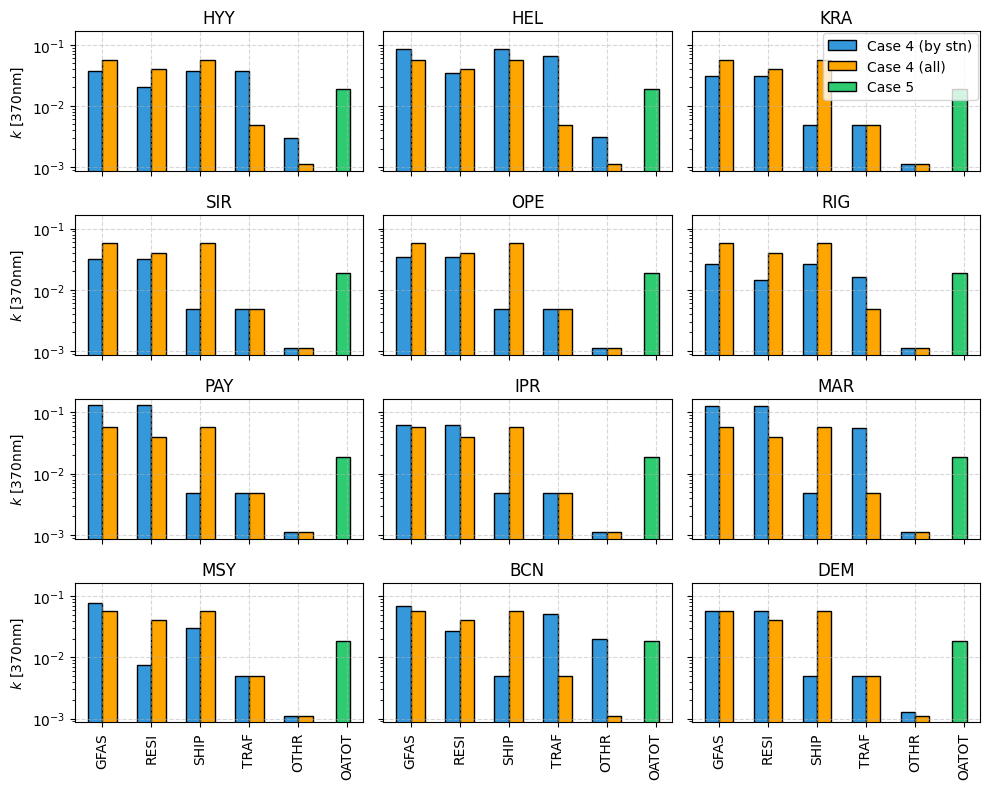

In [7]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 8), sharex=True, sharey=True)

# Aplanar el array de ejes para facilitar su iteración
axes = axes.flatten()

legend_labels = {'c4 (by stn)': 'Case 4 (by stn)', 'c4 (all)': 'Case 4 (all)','c5': 'Case 5'}
new_paleta_colores = ['#3498DB',  # case 4 by stn
                      'orange',  # case 4 all
                      '#2ECC71',  # case 5
                      '#3498DB'] 
hatches = ['/', 'o', 'x', '-']

group_width = 1.5
num_bars = len(legend_labels)
bar_width = group_width / num_bars
group_spacing = 0.2  # Spacing between groups

#handles = [plt.Rectangle((0,0),1,1, color=new_paleta_colores[i], hatch=hatches[i]) for i in range(len(legend_labels))]
handles = [mpatches.Patch(facecolor=new_paleta_colores[i], edgecolor='black') for i in range(len(legend_labels))] #, hatch=hatches[i]
new_order = ['GFAS', 'RESI', 'SHIP', 'TRAF', 'OTHR', 'OATOT']

for i, (stn, df) in enumerate(data_nosoa.items()):
    ax = axes[i]

    # Iterate through the sources and plot bars
    for j, (orig_col, new_label) in enumerate(legend_labels.items()):
        if orig_col == 'c5':  # Assuming 'oa' is the identifier for the 'OA' bar
            # Center the 'OA' bar within its allocated space
            center_offset = (group_width - bar_width) 
            oa_positions = np.arange(len(df)) * (group_width + group_spacing) + .1*center_offset
            ax.bar(oa_positions, df[orig_col], width=bar_width, color=new_paleta_colores[j], edgecolor='black', label=new_label)
        else:
            positions = np.arange(len(df)) * (group_width + group_spacing) + j * bar_width
            ax.bar(positions, df[orig_col], width=bar_width, color=new_paleta_colores[j], edgecolor='black', label=new_label)

    ax.set_yscale('log')
    ax.title.set_text(stn)

    # Set x-ticks to align with the bar centers. Specifically adjust for 'TOTOA'
    tick_positions = np.arange(len(df)) * (group_width + group_spacing) + group_width / 2 - bar_width / 1
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(new_order, rotation=90)
    ax.grid(True, linestyle='--', alpha=0.5)

    if i % 3 == 0:
        ax.set_ylabel('$k$ [370nm]')

plt.tight_layout()
fig.legend(handles, list(legend_labels.values()), loc='upper right', bbox_to_anchor=(.99, .96), ncols=1, facecolor=None)

os.makedirs('figures_paper/ri_optimized/no_soa', exist_ok=True)
fig.savefig(f"figures_paper/ri_optimized/no_soa/opt_newcase.png", dpi=300, bbox_inches='tight')

plt.show()

In [28]:
reg_stns = ['HYY', 'OPE', 'RIG', 'PAY', 'IPR', 'MSY']
sub_stns = ['SIR', 'KRA', 'DEM']
urb_stns = ['BCN', 'MAR', 'HEL']

In [41]:
c_4_r = {}
#get for C4 the 
for stn in urb_stns:
    c_4_r[stn] = data_nosoa[stn]['c4 (by stn)']

df_r = pd.DataFrame(c_4_r)
df_r 

,BCN,MAR,HEL
RI_name,,,
gfas,0.0699,0.1260,0.0843
resi,0.0276,0.1260,0.0340
ship,0.0049,0.0049,0.0843
traf,0.0515,0.0556,0.0666
othr,0.0202,0.0011,0.0031
oa,NaN,NaN,NaN


In [42]:
c_4 = {}
#get for C4 the 
for stn in stations:
    c_4[stn] = data_nosoa[stn]['c4 (by stn)']

In [43]:
df_n = pd.DataFrame(c_4)
#get min and max values for each row
'''df_n['min'] = df_n.min(axis=1)
df_n['max'] = df_n.max(axis=1)

df_n'''
df_n 

,HYY,HEL,KRA,SIR,OPE,RIG,PAY,IPR,MAR,MSY,BCN,DEM
RI_name,,,,,,,,,,,,
gfas,0.0375,0.0843,0.0311,0.0317,0.0348,0.0264,0.1304,0.0629,0.1260,0.0768,0.0699,0.0567
resi,0.0207,0.0340,0.0311,0.0317,0.0348,0.0142,0.1304,0.0629,0.1260,0.0076,0.0276,0.0567
ship,0.0375,0.0843,0.0049,0.0049,0.0049,0.0264,0.0049,0.0049,0.0049,0.0306,0.0049,0.0049
traf,0.0375,0.0666,0.0049,0.0049,0.0049,0.0159,0.0049,0.0049,0.0556,0.0049,0.0515,0.0049
othr,0.0030,0.0031,0.0011,0.0011,0.0011,0.0011,0.0011,0.0011,0.0011,0.0011,0.0202,0.0013
oa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#convert to df and calculate mean and std 
c_4_df = pd.DataFrame(c_4)
c_4_df['mean'] = c_4_df.mean(axis=1)
c_4_df['std'] = c_4_df.std(axis=1)


In [13]:
c_4_df 

,HYY,HEL,KRA,SIR,OPE,RIG,PAY,IPR,MAR,MSY,BCN,DEM,mean,std
RI_name,,,,,,,,,,,,,,
gfas,0.0375,0.0843,0.0311,0.0317,0.0348,0.0264,0.1304,0.0629,0.1260,0.0768,0.0699,0.0567,0.064042,0.034172
resi,0.0207,0.0340,0.0311,0.0317,0.0348,0.0142,0.1304,0.0629,0.1260,0.0076,0.0276,0.0567,0.048142,0.038761
ship,0.0375,0.0843,0.0049,0.0049,0.0049,0.0264,0.0049,0.0049,0.0049,0.0306,0.0049,0.0049,0.018167,0.023054
traf,0.0375,0.0666,0.0049,0.0049,0.0049,0.0159,0.0049,0.0049,0.0556,0.0049,0.0515,0.0049,0.021783,0.022935
othr,0.0030,0.0031,0.0011,0.0011,0.0011,0.0011,0.0011,0.0011,0.0011,0.0011,0.0202,0.0013,0.003033,0.005225
oa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
def process_data(df, urb_stns):
    # Filter data for urban stations
    data_nosoa_urb = {k: df[k] for k in urb_stns}

    # Create individual DataFrames and set index
    frames = {}
    for location, d in data_nosoa_urb.items():
        df_temp = pd.DataFrame(d)
        frames[location] = df_temp

    # Combine into a single DataFrame with MultiIndex columns
    df_combined_urb = pd.concat(frames, axis=1).T

    # Calculate median, mean, and std deviation for each category
    results = []
    categories = ['C1', 'C2', 'C3', 'C4']
    for cat in categories:
        df_cat = df_combined_urb.xs(cat, level=1).drop('oa', axis=1)
        #median = df_cat.median(axis=0).round(4)
        std = df_cat.std(axis=0).round(4)
        mean = df_cat.mean(axis=0).round(4)
        df_med_std_mean = pd.DataFrame([mean, std], index=['mean', 'std']) #median
        df_med_std_mean['Case'] = cat
        results.append(df_med_std_mean)

    # Concatenate all the dataframes
    df_med_std_urb = pd.concat(results)

    return df_med_std_urb

# Example usage:
# Assuming 'df' is your DataFrame and 'urb_stns' is a list of urban station identifiers
# result_df = process_data(df, urb_stns)

In [81]:
data_nosoa = {}

# Iterar sobre cada estación
for stn in stations:
    # Cargar los dataframes para la estación actual
    weakly_by_stn = pd.read_csv(f"{path_ri}monarch_best_weakly/RI_by_station/no_secondary/RI_{method}_{dict_of_names['acr_first'][stn]}_best.csv", index_col=0)
    moderately_by_stn = pd.read_csv(f"{path_ri}monarch_best_moderately/RI_by_station/no_secondary/RI_{method}_{dict_of_names['acr_first'][stn]}_best.csv", index_col=0)
    strongly_by_stn = pd.read_csv(f"{path_ri}monarch_best_strongly/RI_by_station/no_secondary/RI_{method}_{dict_of_names['acr_first'][stn]}_best.csv", index_col=0)
    new_case = pd.read_csv(f"{path_ri}monarch_best_newcase/RI_by_station/no_secondary/RI_{method}_{dict_of_names['acr_first'][stn]}_best.csv", index_col=0)
    oa_by_stn = pd.read_csv(f"{path_ri}monarch_best_oa/RI_by_station/RI_{method}_{dict_of_names['acr_first'][stn]}_best.csv", index_col=0) 
    
    # Unir los DataFrames
    df_unido = pd.concat([weakly_by_stn, moderately_by_stn, strongly_by_stn, new_case, oa_by_stn], axis=1)
    
    # Renombrar las columnas para que reflejen las categorías 'w', 'm', 's'
    num_columnas = len(weakly_by_stn.columns)
    nuevas_columnas = ['C1', 'C2', 'C3', 'C4', 'C5']
    df_unido.columns = nuevas_columnas
    
    # Asignar el dataframe combinado al diccionario para la estación actual
    data_nosoa[stn] = df_unido

In [82]:
reg_stns = ['HYY', 'OPE', 'RIG', 'PAY', 'IPR', 'MSY']
sub_stns = ['SIR', 'KRA', 'DEM']
urb_stns = ['BCN', 'MAR', 'HEL']

In [83]:
df_urb = process_data(data_nosoa, urb_stns)
df_urb['Setting'] = 'URB'
df_reg = process_data(data_nosoa, reg_stns)
df_reg['Setting'] = 'REG'
df_sub = process_data(data_nosoa, sub_stns)
df_sub['Setting'] = 'SUB'

In [84]:
df_sub 

RI_name,gfas,resi,ship,traf,othr,Case,Setting
mean,0.0409,0.0409,0.0049,0.0011,0.0014,C1,SUB
std,0.0154,0.0154,0.0000,0.0000,0.0005,C1,SUB
mean,0.0403,0.0403,0.0191,0.0011,0.0013,C2,SUB
std,0.0148,0.0148,0.0017,0.0000,0.0003,C2,SUB
mean,0.1219,0.0395,0.0181,0.0011,0.0011,C3,SUB
std,0.0000,0.0135,0.0000,0.0000,0.0000,C3,SUB
mean,0.0398,0.0398,0.0049,0.0049,0.0012,C4,SUB
std,0.0146,0.0146,0.0000,0.0000,0.0001,C4,SUB


In [85]:
df_combined = pd.concat([df_urb, df_reg, df_sub])

# Establecer 'Setting' como índice del DataFrame combinado
#df_combined.set_index('Setting', inplace=True)

In [89]:

data_arranged = {
    'Metric': df_combined.index,
    'GFAS': df_combined['gfas'].values,
    'RESI': df_combined['resi'].values,
    'SHIP': df_combined['ship'].values,
    'TRAF': df_combined['traf'].values,
    'OTHR': df_combined['othr'].values,
    'Setting': df_combined['Setting'].values,
    'Case': df_combined['Case'].values
}

In [102]:
df = pd.DataFrame(data_arranged)
df.set_index(['Setting', 'Case', 'Metric'], inplace=True)
df = df.unstack(level='Metric')
df

GFAS            RESI            SHIP            TRAF          \
Metric          mean     std    mean     std    mean     std    mean     std   
Setting Case                                                                   
REG     C1    0.0619  0.0396  0.0458  0.0469  0.0196  0.0168  0.0093  0.0141   
        C2    0.0506  0.0434  0.0482  0.0448  0.0210  0.0071  0.0070  0.0139   
        C3    0.1241  0.0053  0.0476  0.0447  0.0527  0.0536  0.0068  0.0140   
        C4    0.0615  0.0387  0.0451  0.0462  0.0182  0.0150  0.0122  0.0132   
SUB     C1    0.0409  0.0154  0.0409  0.0154  0.0049  0.0000  0.0011  0.0000   
        C2    0.0403  0.0148  0.0403  0.0148  0.0191  0.0017  0.0011  0.0000   
        C3    0.1219  0.0000  0.0395  0.0135  0.0181  0.0000  0.0011  0.0000   
        C4    0.0398  0.0146  0.0398  0.0146  0.0049  0.0000  0.0049  0.0000   
URB     C1    0.0924  0.0354  0.0635  0.0535  0.0418  0.0481  0.0354  0.0000   
        C2    0.0998  0.0238  0.0635  0.0534  0.0445  0.0456  0.0354  0.0000   
        C3    0.1229  0.0017  0.0634  0.0535  0.0527  0.0599  0.0345  0.0015   
        C4    0.0934  0.0291  0.0625  0.0551  0.0314  0.0458  0.0579  0.0078   

                OTHR          
Metric          mean     std  
Setting Case                  
REG     C1    0.0015  0.0009  
        C2    0.0018  0.0010  
        C3    0.0014  0.0005  
        C4    0.0014  0.0008  
SUB     C1    0.0014  0.0005  
        C2    0.0013  0.0003  
        C3    0.0011  0.0000  
        C4    0.0012  0.0001  
URB     C1    0.0098  0.0109  
        C2    0.0092  0.0102  
        C3    0.0091  0.0110  
        C4    0.0081  0.0105

In [105]:
df_final = df.style.format(subset=['GFAS', 'RESI', 'SHIP', 'TRAF', 'OTHR'], precision=4)
latex_df = df_final.to_latex(
    caption="Selected statistics",
    clines="skip-last;data",
    convert_css=True,
    position_float="centering",
    multicol_align="|c|",
    hrules=True,
)
print(latex_df)

\begin{table}
\centering
\caption{Selected statistics}
\begin{tabular}{llrrrrrrrrrr}
\toprule
 &  & \multicolumn{2}{|c|}{GFAS} & \multicolumn{2}{|c|}{RESI} & \multicolumn{2}{|c|}{SHIP} & \multicolumn{2}{|c|}{TRAF} & \multicolumn{2}{|c|}{OTHR} \\
 & Metric & mean & std & mean & std & mean & std & mean & std & mean & std \\
Setting & Case &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[c]{4}{*}{REG} & C1 & 0.0619 & 0.0396 & 0.0458 & 0.0469 & 0.0196 & 0.0168 & 0.0093 & 0.0141 & 0.0015 & 0.0009 \\
 & C2 & 0.0506 & 0.0434 & 0.0482 & 0.0448 & 0.0210 & 0.0071 & 0.0070 & 0.0139 & 0.0018 & 0.0010 \\
 & C3 & 0.1241 & 0.0053 & 0.0476 & 0.0447 & 0.0527 & 0.0536 & 0.0068 & 0.0140 & 0.0014 & 0.0005 \\
 & C4 & 0.0615 & 0.0387 & 0.0451 & 0.0462 & 0.0182 & 0.0150 & 0.0122 & 0.0132 & 0.0014 & 0.0008 \\
\cline{1-12}
\multirow[c]{4}{*}{SUB} & C1 & 0.0409 & 0.0154 & 0.0409 & 0.0154 & 0.0049 & 0.0000 & 0.0011 & 0.0000 & 0.0014 & 0.0005 \\
 & C2 & 0.0403 & 0.0148 & 0.0403 & 0.0148 & 0.0191 & 0.0017 & 0.0

In [ ]:
ut.calculate_abs_newcase_all()

# SCATTER PLOTS

In [3]:
def calculate_statistics_nosoa(stn, points, mode='by_station'):
    # Calcula los valores para cada caso y la observación
    abs_mod_weakly = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                   SA=False, mode=mode, points=points, model='monarch_best', case='weakly')
    abs_mod_moderately = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                       SA=False, mode=mode, points=points, model='monarch_best', case='moderately')
    abs_mod_strongly = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                     SA=False, mode=mode, points=points, model='monarch_best', case='strongly')
    abs_mod_newcase = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                        SA=False, mode=mode, points=points, model='monarch_best', case='newcase')
    abs_observed = dr.get_obsabs370(dict_of_names['acr_first'][stn], remove_negatives=True)

    abs_tot_oa = ut.calculate_absorption4oa_ns(dict_of_names['acr_first'][stn], best=True, points=points,\
                                             mass_mode='best', mode=mode, model='monarch_best_oa')
    abs_newcase_all = ut.calculate_abs_newcase_all(dict_of_names['acr_first'][stn], best=True, points=points,\
                                                mass_mode='best', mode=mode, model='monarch_best_newcase')
    #hacer collocation de los datos para cada caso 
    #abs_observed, abs_mod_weakly = st.preproc_data_collocation(abs_observed, abs_mod_weakly, filled=False)
    #abs_observed, abs_mod_moderately = st.preproc_data_collocation(abs_observed, abs_mod_moderately, filled=False)
    #abs_observed, abs_mod_strongly = st.preproc_data_collocation(abs_observed, abs_mod_strongly, filled=False)
    #abs_observed, abs_tot = st.preproc_data_collocation(abs_observed, abs_tot_oa, filled=False)
    # Calcular las métricas
    corr_weakly = st.calculate_corr(abs_observed, abs_mod_weakly)
    corr_moderately = st.calculate_corr(abs_observed, abs_mod_moderately)
    corr_strongly = st.calculate_corr(abs_observed, abs_mod_strongly)
    corr_newcase = st.calculate_corr(abs_observed, abs_mod_newcase)
    corr_tot = st.calculate_corr(abs_observed, abs_tot_oa)
    corr_tot_newcase = st.calculate_corr(abs_observed, abs_newcase_all)
    fb_weakly = st.calculate_fb(abs_observed, abs_mod_weakly)
    fb_moderately = st.calculate_fb(abs_observed, abs_mod_moderately)
    fb_strongly = st.calculate_fb(abs_observed, abs_mod_strongly)
    fb_newcase = st.calculate_fb(abs_observed, abs_mod_newcase)
    fb_tot = st.calculate_fb(abs_observed, abs_tot_oa)
    fb_tot_newcase = st.calculate_fb(abs_observed, abs_newcase_all)
    fac2_weakly = st.calculate_fac2(abs_observed, abs_mod_weakly)
    fac2_moderately = st.calculate_fac2(abs_observed, abs_mod_moderately)
    fac2_strongly = st.calculate_fac2(abs_observed, abs_mod_strongly)
    fac2_newcase = st.calculate_fac2(abs_observed, abs_mod_newcase)
    fac2_tot = st.calculate_fac2(abs_observed, abs_tot_oa)
    fac2_tot_newcase = st.calculate_fac2(abs_observed, abs_newcase_all)

    # Crear un diccionario para almacenar los resultados para cada caso
    resultados = {
        'weakly': {
            'r': corr_weakly,
            'fb': fb_weakly,
            'fac2': fac2_weakly
        },
        'moderately': {
            'r': corr_moderately,
            'fb': fb_moderately,
            'fac2': fac2_moderately
        },
        'strongly': {
            'r': corr_strongly,
            'fb': fb_strongly,
            'fac2': fac2_strongly
        },
        'newcase': {
            'r': corr_newcase,
            'fb': fb_newcase,
            'fac2': fac2_newcase
        },
        'totnewcase': {
            'r': corr_tot_newcase,
            'fb': fb_tot_newcase,
            'fac2': fac2_tot_newcase
        },
        'total': {
            'r': corr_tot,
            'fb': fb_tot,
            'fac2': fac2_tot

        }
    }

    return resultados

In [7]:
calculate_statistics_nosoa('HEL', points='complete', mode='by_station')

{'weakly': {'r': 0.55, 'fb': 10.48, 'fac2': 73.42},
 'moderately': {'r': 0.54, 'fb': 10.11, 'fac2': 73.15},
 'strongly': {'r': 0.55, 'fb': 9.39, 'fac2': 73.42},
 'newcase': {'r': 0.54, 'fb': 11.56, 'fac2': 74.79},
 'totnewcase': {'r': 0.51, 'fb': -7.46, 'fac2': 64.38},
 'total': {'r': 0.48, 'fb': 20.22, 'fac2': 78.08}}

In [12]:
station_names = list(dict_of_names['acr_first'].keys())
station_names 

['DEM',
 'BCN',
 'MSY',
 'MAR',
 'IPR',
 'PAY',
 'RIG',
 'OPE',
 'SIR',
 'KRA',
 'HEL',
 'HYY']

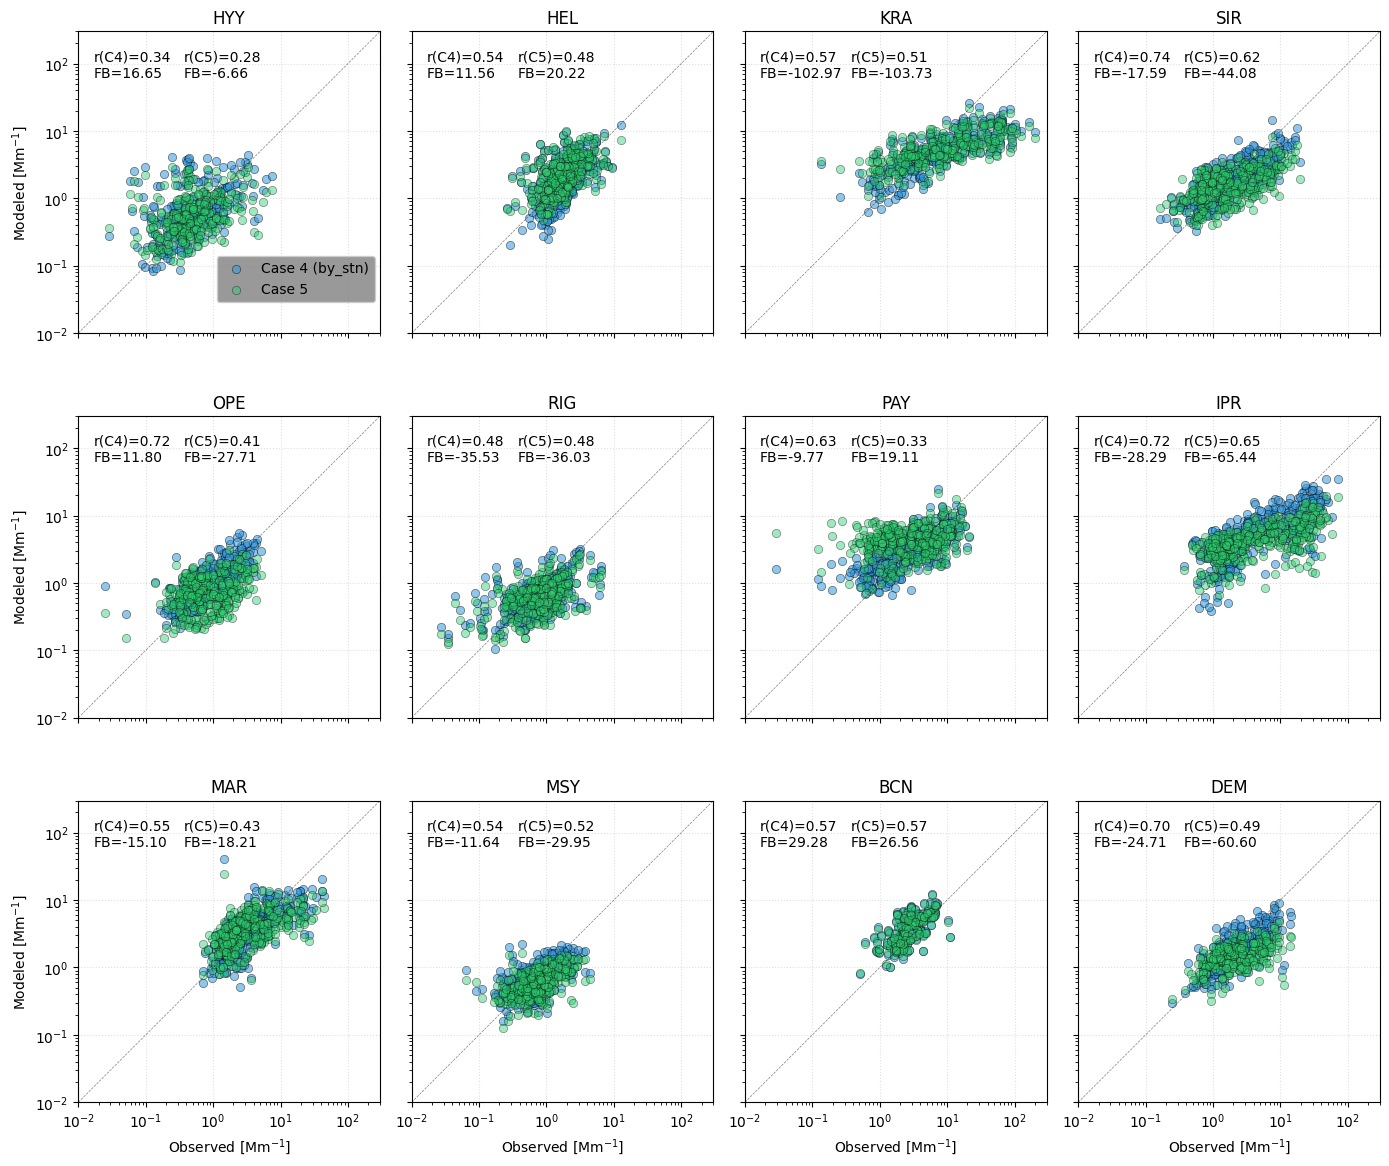

In [20]:
'''
'#3498DB',  # case 4 by stn
'orange',  # case 4 all
'#2ECC71',  # case 5
'''

def plot_scatter_log_c(stations, mode='by_station', points='best'):
    #plot in one figure
    fig, axs = plt.subplots(3, 4, figsize=(14, 14), sharex=True, sharey=True)
    #reduce space between subplots
    fig.subplots_adjust(hspace=-0.45, wspace=0.12)
    #flatten the axs
    axs = axs.flatten()
    #ri_tables/monarch_best_strongly/RI_all/no_secondary/
    for i, stn in enumerate(stations):
        # Calcula los valores para cada caso y la observación
        #abs_mod_weakly = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
        #                                               SA=False, mode=mode, points=points, model='monarch_best', case='weakly')
        #abs_mod_moderately = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
        #                                                   SA=False, mode=mode, points=points, model='monarch_best', case='moderately')
        abs_oa_newcase = ut.calculate_absorption_cases_nosoa(dict_of_names['acr_first'][stn], best=True, mass_mode='best',\
                                                         SA=False, mode=mode, points=points, model='monarch_best', case='newcase')
        abs_oa = ut.calculate_absorption4oa_ns(dict_of_names['acr_first'][stn], best=True, points=points,\
                                                mass_mode='best', mode=mode, model='monarch_best_oa')
        abs_oa_newcase_all = ut.calculate_abs_newcase_all(dict_of_names['acr_first'][stn], best=True, points=points,\
                                                        mass_mode='best', mode=mode, model='monarch_best_newcase')  
        abs_observed = dr.get_obsabs370(dict_of_names['acr_first'][stn], remove_negatives=True)


        #axs[i].scatter(abs_observed, abs_mod_weakly, color='#27AE60', label='Case 1', alpha=0.8, marker='s')
        #axs[i].scatter(abs_observed, abs_mod_moderately, color='#F1C40F', label='Case 2', alpha=0.9, marker='x', linewidth=1.5)
        axs[i].scatter(abs_observed, abs_oa_newcase, color='#3498DB' if mode == 'by_station' else 'orange', label=f'Case 4 ({"by_stn" if mode=="by_station" else mode})', alpha=0.55, edgecolor='black', linewidth=0.5)
        axs[i].scatter(abs_observed, abs_oa, color='#2ECC71', label='Case 5', alpha=0.45, edgecolor='black', linewidth=0.5)
        axs[i].minorticks_on()
        axs[i].set_xlim([0.01, 300])
        axs[i].set_ylim([0.01,300])

        #plot a diagonal line
        axs[i].plot([0.01, 300], [0.01, 300], linestyle='--', color='black', alpha=0.5, linewidth=0.5)
        #set title
        axs[i].set_title(stn)
        #set axis labels just in the bottom and left subplots
        if i in [8, 9, 10, 11]:
            axs[i].set_xlabel('Observed [Mm$^{-1}$]')
        if i in [0, 4, 8]:
            axs[i].set_ylabel('Modeled [Mm$^{-1}$]')
        #add annotation with correlation coefficient, and mean bias for each case/station using the function calculate_statistics
        #calculate statistics
        results = calculate_statistics_nosoa(stn, points, mode=mode)
        #add annotation
        axs[i].annotate(f"r(C4)={results['newcase']['r']:.2f}\nFB={results['newcase']['fb']:.2f}", 
                        xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10)
        axs[i].annotate(f"r(C5)={results['total']['r']:.2f}\nFB={results['total']['fb']:.2f}", 
                        xy=(0.35, 0.85), xycoords='axes fraction', fontsize=10)
        #axs[i].annotate(f"r(c3)={results['strongly']['r']:.2f}\nFB={results['strongly']['fb']:.2f}", 
        #                xy=(0.65, 0.85), xycoords='axes fraction', fontsize=10)

        #set log scale
        axs[i].set_xscale('log')


        axs[i].set_yscale('log')
        #set grid dotted
        axs[i].grid(True, linestyle=':', alpha=0.4)
        axs[i].set_aspect('equal', adjustable='box')
        #add legend in bottom of only first subplot
        axs[0].legend(loc='lower center', bbox_to_anchor=(0.78 if mode == 'all' else 0.72, 0.08), ncol=1, facecolor='gray')
    # Ajustar el layout para evitar la superposición
    plt.tight_layout()

    os.makedirs('figures_paper/scatter_opt/', exist_ok=True)
    #savefig 
    plt.savefig(f"figures_paper/scatter_opt/scatter_opt_cases_{points}_{mode}_newcase.png", dpi=300, bbox_inches='tight')
    plt.show()

plot_scatter_log_c(station_names[::-1], mode='by_station', points='complete')